In [2]:
import warnings
warnings.filterwarnings("ignore")
import pyart
import numpy as np
from pyart.retrieve import get_freq_band
from matplotlib import pyplot as plt
import glob, os

In [3]:
def _align_field(field):
    values, counts = np.unique(field['data'], return_counts=True)
    c_value = values[np.argmax(counts)]
    field['data'] = np.array([c_value])
    return field

def align_radar_coords(radar):
    for field_name in ['longitude', 'latitude', 'altitude', 'altitude_agl']:
        setattr(radar, field_name, _align_field(getattr(radar, field_name)))
    return radar

In [4]:
def despeck(radar, field, gf):
    gf_despeckeld = pyart.correct.despeckle_field(radar, field, gatefilter=gf)
    corr_ZH = radar.fields[field].copy()
    ZH_array = np.ma.masked_where(gf_despeckeld.gate_included == False, radar.fields[field]['data'])
    smooth_data = scipy.ndimage.median_filter(ZH_array, 3)
    corr_ZH['data'] = smooth_data
    radar.add_field(field+"_C", corr_ZH, replace_existing=True)
    return radar

In [6]:
# radar = despeck(radar, refl_field, gf)
# radar = despeck(radar, vel_field, gf)
# radar = despeck(radar, 'ZDRC', gf)
# radar = despeck(radar, 'RHOHV', gf)

In [ ]:
def plot_radar(radar):
    # Let us view the vleocity with the filter applied.
    fig = plt.figure(figsize=[10, 8])
    display = pyart.graph.RadarMapDisplay(radar)
    ax = plt.subplot(221)
    display.plot_ppi('DBZHCC_F_CORR', vmin=-10., vmax=70., cmap='pyart_HomeyerRainbow', gatefilter=gf)
    ax = plt.subplot(222)
    display.plot_ppi("VEL_F_CORR", vmin=-35., vmax=35., cmap='pyart_NWSVel', gatefilter=gf)
    ax = plt.subplot(223)
    display.plot_ppi("ZDRC_CORR", vmin=-7., vmax=7., cmap='pyart_RefDiff', gatefilter=gf)
    ax = plt.subplot(224)
    display.plot_ppi("RHOHV_CORR", vmin=0., vmax=1., cmap='pyart_RefDiff', gatefilter=gf)
plot_radar(radar)

In [175]:
def filter_radar(radar, vel_field="VEL_F", refl_field="DBZHCC_F", 
                 ncp_field="NCP", rhv_field="RHOHV", phi_field="PHIDP"):
    '''Remove noise based on velocity texture and mask all the fields'''
    # Drop some fields
    fields_to_drop = ["DBMHC", "DBMVC", "VS", "VS_F", "VL", "VL_F", "DBZHCC"]
    for field in fields_to_drop:
        if field in radar.fields:
            del radar.fields[field]
        
#     texture = pyart.retrieve.calculate_velocity_texture(radar, 
#                                                         vel_field=vel_field, 
#                                                         wind_size=5, 
#                                                         check_nyq_uniform=False)
#     radar.add_field('VT',texture,replace_existing=True)
    # create gatefilter
    gf = pyart.filters.GateFilter(radar)
    BAND = get_freq_band(radar.instrument_parameters['frequency']['data'])
    if BAND == "X":
        vt = 5
    elif BAND == "C":
        vt = 40
#     gf.exclude_above('VT', vt)
    gf.exclude_outside(refl_field, -30, 100)
    gf.include_inside(refl_field, )
    gf.include_above(refl_name, refl_thresh)
    gf.exclude_below("SNRHC", -3)
    gf_despeckeld = pyart.correct.despeckle_field(radar, refl_field, gatefilter=gf)
    corr_ZH = radar.fields[refl_field].copy()
    ZH_array = np.ma.masked_where(gf_despeckeld.gate_included == False, radar.fields[refl_field]['data'])
    corr_ZH['data'] = ZH_array
    radar.add_field('DBZH',corr_ZH,replace_existing=True)
    
    # get the mask
    mask = np.ma.getmask(radar.fields['DBZH']['data'])
    # iterate through remaining fields
    skip_fields = ["DBZHC", "VEL"]
    for field in radar.fields.keys():
        if any(field == skip_field for skip_field in skip_fields):
            continue
        # mask the field
        radar.fields[field]['data'] = np.ma.masked_where(mask, radar.fields[field]['data'])
    radar.scan_type = b'ppi'
    return radar

In [7]:
def filter_data(radar, refl_field, refl_thresh, vel_field, ncp_field, ncp_thresh=0.4):
    texture = pyart.retrieve.calculate_velocity_texture(radar,
                                                        vel_field=vel_field,
                                                        wind_size=15,
                                                        check_nyq_uniform=False
                                                       )
    radar.add_field('VT',texture,replace_existing=True)
    gatefilter = pyart.filters.GateFilter(radar)
    gatefilter.include_above(refl_field, refl_thresh)
    gatefilter.include_inside(refl_field, 10, 70)
    gatefilter.exclude_above("TRIP_FLA", 1)
    gatefilter.include_above("SNRHC", -5)
    gatefilter.exclude_above("VT", 30)
    radar = mask_data(radar, refl_field, gatefilter, True)
    radar = mask_data(radar, vel_field, gatefilter, True)
#     gatefilter_ref = pyart.filters.moment_based_gate_filter(radar, ncp_field=ncp_field, min_ncp=ncp_thresh,)
#     radar = mask_data(radar, refl_field, gatefilter_ref, True)
    return radar

In [181]:
def mask_data(radar, moment, gatefilter, masking=True):
    if masking:
        dsp=pyart.correct.despeckle_field(radar, moment, gatefilter=gatefilter, size= 15)
        mom_masked= np.ma.masked_where(dsp.gate_included == False, radar.fields[moment]['data'])
    else:
        mom_masked=moment
    radar.add_field(moment, {'data':mom_masked}, replace_existing=True)
    return radar

In [182]:
import sys
sys.path.append("universal_defs")

In [183]:
from radar_cmap import rcmap

In [184]:
def plot_radar(radar, refl_field=None, vel_field=None, corrected=True):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    display = pyart.graph.RadarMapDisplay(radar)
    if corrected:
        field1 = '{}_C'.format(refl_field)
        field2 = '{}_C'.format(vel_field)
    else:
        field1 = refl_field
        field2 = vel_field
    display.plot_ppi(field1, vmin=-10., vmax=70., 
                     cmap=rcmap, ax=ax1)
    
    display.plot_ppi(field2, vmin=-35., vmax=35., 
                         cmap='pyart_NWSVel', ax=ax2)
    for ax in [ax1, ax2]:
        ax.set_xlim(-65, -45)
        ax.set_ylim(-20, 15)

In [185]:
basedir = "/depot/dawson29/data/Projects/PERiLS/obsdata/2022/Illinois_Mobile_Radar/IOP1/"
cow = os.path.join(basedir, "COW1/cmerged/20220322/")
files = glob.glob(os.path.join(cow, "*"))
files.sort()
len(files)

181

In [90]:
radar = align_radar_coords(pyart.io.read_cfradial(files[112]))
refl_field = "DBZHCC_F"
vel_field = "VEL_F"
ncp_field = "NCP"
radar = filter_data(radar, refl_field, 5, vel_field, ncp_field)

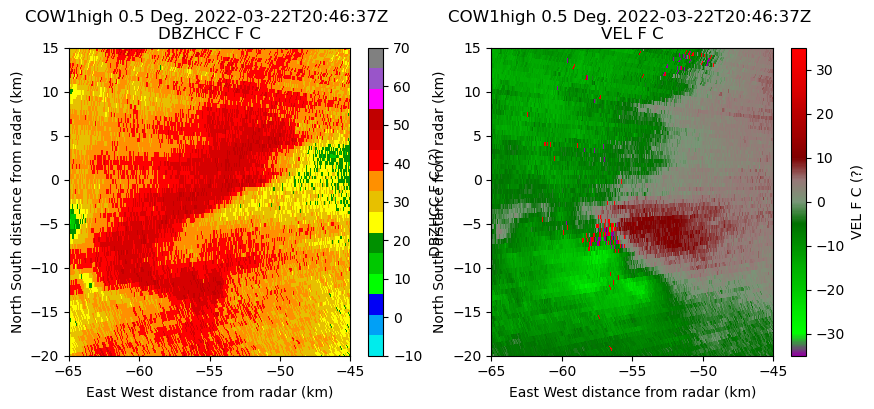

In [45]:
plot_radar(radar,refl_field, vel_field, corrected=True)

In [ ]:
import pymeso

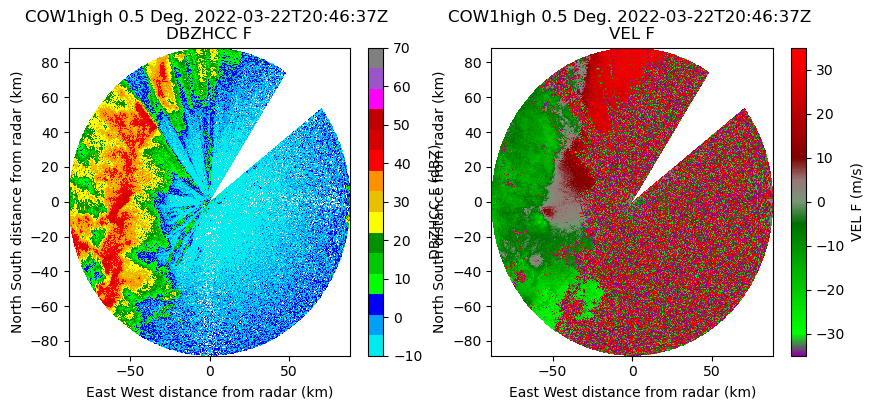

In [28]:
plot_radar(radar,refl_field, vel_field, corrected=False)

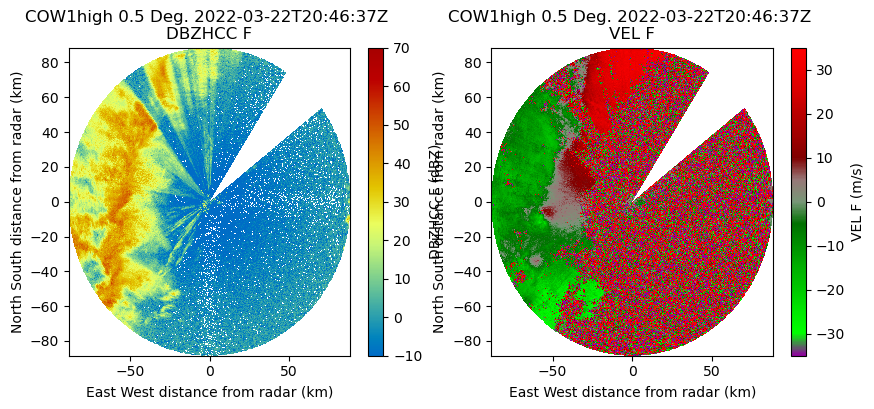

In [97]:
plot_radar(radar, corrected=False)

In [280]:
def filter_data(radar, refl_field, refl_thresh, vel_field, ncp_field, ncp_thresh=0.4):
    '''Remove noise based on velocity texture and mask all the fields'''
    # Drop some fields
    fields_to_drop = ["DBMHC", "DBMVC", "VS", "VS_F", "VL", "VL_F", "DBZHCC"]
    for field in fields_to_drop:
        if field in radar.fields:
            del radar.fields[field]
    
    texture = pyart.retrieve.calculate_velocity_texture(radar,
                                                        vel_field=vel_field,
                                                        wind_size=15,
                                                        check_nyq_uniform=False
                                                       )
    radar.add_field('VT',texture,replace_existing=True)
    gatefilter = pyart.filters.GateFilter(radar)
    gatefilter.include_above(refl_field, refl_thresh)
    gatefilter.include_inside(refl_field, 10, 70)
    gatefilter.exclude_above("TRIP_FLA", 1)
    gatefilter.include_above("SNRHC", -5)
    gatefilter.exclude_above("VT", 30)
    gatefilter.exclude_below("NCP", 0.1)
    gatefilter.exclude_below("RHOHV", 0.7)
    gatefilter.exclude_transition()
    radar = mask_data(radar, refl_field, gatefilter, True)
    radar = mask_data(radar, vel_field, gatefilter, True)
    mask = np.ma.getmask(radar.fields['DBZHCC_F']['data'])
    # iterate through remaining fields
    skip_fields = ["DBZHC", "VEL", "VEL_F", "DBZHCC_F"]
    for field in radar.fields.keys():
        if any(field == skip_field for skip_field in skip_fields):
            continue
        # mask the field
        radar.fields[field]['data'] = np.ma.masked_where(mask, radar.fields[field]['data'])
    radar.scan_type = b'ppi'
    return radar

In [ ]:
radar = align_radar_coords(pyart.io.read_cfradial(files[112]))
refl_field = "DBZHCC_F"
vel_field = "VEL_F"
ncp_field = "NCP"
radar = filter_data(radar, refl_field, 5, vel_field, ncp_field)

In [ ]:
import time
from pymeso import llsd

#function to dealiase the Doppler velocity
def dealiase(radar, vel_name):
    #check to see if radar object has nyquist velocity
    try: 
        gatefilter = pyart.correct.GateFilter(radar)
        corr_vel   = pyart.correct.dealias_unwrap_phase(
            radar, vel_field=vel_name, keep_original=False, gatefilter = gatefilter)
        radar.add_field(vel_name, corr_vel, True)
    except:
        None


# def dealiase2(radar, vel_name):
#     #check to see if radar object has nyquist velocity
#     try: 
#         gatefilter = pyart.correct.GateFilter(radar)
#         corr_vel   = pyart.correct.dealias_region_based(
#             radar, vel_field=vel_name, keep_original=False, gatefilter = gatefilter)
#         radar.add_field(vel_name, corr_vel, True)
#     except:
#         None

#dealiase Doppler field
# dealiase2(radar,'VEL_F_C')
dealiase(radar,'VEL_F')

In [ ]:
#call the llsd function form llsd.py
start_time = time.time()
az_shear_meta = llsd.main(radar,'DBZHCC_F','VEL_F', window_size = (1000, 3500))
print("LLSD COMPUTE --- %s seconds ---" % (time.time() - start_time))
radar.add_field('AZS', az_shear_meta, replace_existing=True)

In [ ]:
import matplotlib.patches as mpatch

In [ ]:
def plot_radar(radar, refl_field=None, vel_field=None, corrected=True, limits=False):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
    display = pyart.graph.RadarMapDisplay(radar)
    if corrected:
        field1 = '{}_C'.format(refl_field)
        field2 = '{}_C'.format(vel_field)
    else:
        field1 = refl_field
        field2 = vel_field
    display.plot_ppi(field1, vmin=-10., vmax=70., 
                     cmap='pyart_NWSRef', ax=ax1)
    
    display.plot_ppi(field2, vmin=-35., vmax=35., 
                         cmap='pyart_NWSVel', ax=ax2)
    display.plot_ppi("AZS", vmin=-10., vmax=10., 
                         cmap='RdBu', ax=ax3)
    if limits:
        for ax in [ax1, ax2, ax3]:
            ax.set_xlim(-65, -45)
            ax.set_ylim(-20, 15)
            ptch = plt.Circle((-57, -6), 5, ec="k", fc='none')
            ax.add_patch(ptch,)
    

In [ ]:
def plot_radar2(radar, limits=False):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
    display = pyart.graph.RadarMapDisplay(radar)
    
    display.plot_ppi("RHOHV", vmin=0.5, vmax=1., 
                     cmap='turbo', ax=ax1)
    
    display.plot_ppi("NCP", vmin=0, vmax=1,
                         cmap='turbo', ax=ax2)
    display.plot_ppi("WIDTH", vmin=0, vmax=5., 
                         cmap=pyart.graph.cm.NWS_SPW, ax=ax3)
    if limits:
        for ax in [ax1, ax2, ax3]:
            ax.set_xlim(-65, -45)
            ax.set_ylim(-20, 15)
            ptch = plt.Circle((-57, -6), 5, ec="k", fc='none')
            ax.add_patch(ptch,)
#         ax.set_aspect('equal')

In [ ]:
plot_radar(radar, refl_field, vel_field, False)

In [ ]:
plot_radar(radar, refl_field, vel_field, False, True)

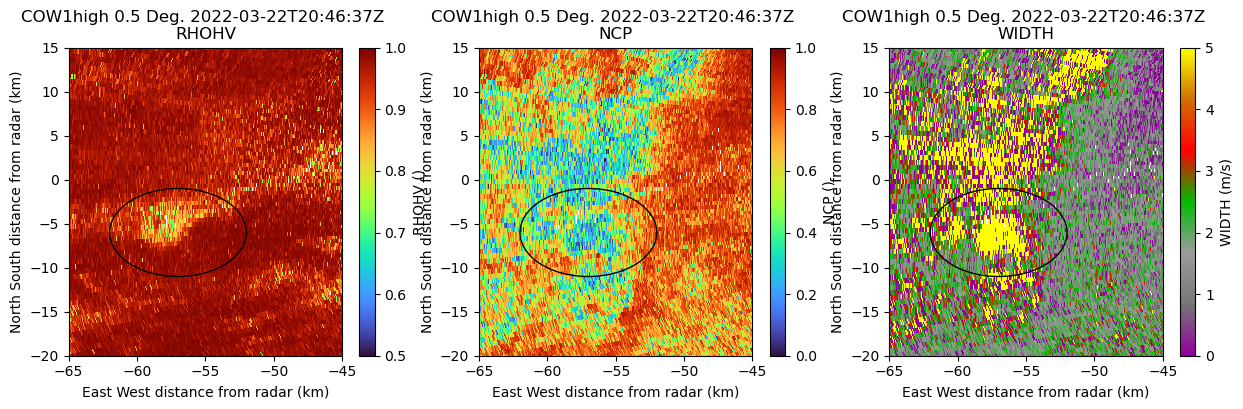

In [278]:
plot_radar2(radar, limits=True)

In [279]:
radar.fields.keys()

dict_keys(['NCP', 'TRIP_FLA', 'SNRHC', 'SNRVC', 'DBZHC', 'DBZHC_F', 'DBZVC', 'DBZVC_F', 'VEL', 'VEL_F', 'WIDTH', 'ZDRM', 'RHOHV', 'PHIDP', 'KDP', 'DBZHCC_F', 'ZDRC', 'VT', 'AZS'])